In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, make_scorer, plot_confusion_matrix
from wordcloud import WordCloud

from sklearn.naive_bayes import MultinomialNB
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

from imblearn.over_sampling import SMOTENC, SMOTE
from imblearn.pipeline import Pipeline as imbPipeline

import matplotlib.pyplot as plt
import seaborn as sns

from code.cleaner import preprocess
from code.viz import word_plot

sns.set()

In [2]:
sentiments = pd.read_csv('./data/judge-1377884607_tweet_product_company.csv',encoding='ISO-8859-1')
sentiments.tail()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product
9092,Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...,NaN,No emotion toward brand or product


In [3]:
sentiments.rename(columns={
    'emotion_in_tweet_is_directed_at':'product',
    'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'
},inplace=True)

In [4]:
sentiments.dropna(subset=['tweet_text'],inplace=True)

In [5]:
reclassify = sentiments[sentiments['sentiment'] == "I can't tell"]
sentiments = sentiments[sentiments['sentiment'] != "I can't tell"]

In [6]:
sentiments['product'].value_counts()

iPad                               942
Apple                              659
iPad or iPhone App                 470
Google                             429
iPhone                             296
Other Google product or service    292
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

In [7]:
sentiments['sentiment'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: sentiment, dtype: int64

In [8]:
sw = stopwords.words('english')
specific_words = ['@mention','link','sxsw','#sxsw','@sxsw']
# ^^ these are the original extended stop words from initial data
# discovery and knowledge 
discovered_words = [
    'google','iphone', 'ipad', 'android', 'app',
    'apple', 'rt', 'quot', 'store', 'new', 'austin'
    ]
specific_words.extend(discovered_words)
sw.extend(specific_words)

In [9]:
# plot for feature importance


nb = MultinomialNB()

nb.fit(X_train_vectorized, y_train)

feature_importances = nb.coef_[0]

feature_importances_sorted = sorted(zip(feature_importances, vectorizer.get_feature_names()), reverse=True)

N = 20
top_features = [f[1] for f in feature_importances_sorted[:N]]
top_importances = [f[0] for f in feature_importances_sorted[:N]]

plt.barh(np.arange(len(top_features)), top_importances)
plt.yticks(np.arange(len(top_features)), top_features)
plt.title('Top {} Most Important Features'.format(N))
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

NameError: name 'X_train_vectorized' is not defined

### Fitting a Naive Bayes Model

$$
\begin{bmatrix}
 & \text{Negative} & \text{Neutral} & \text{Positive} \\
\text{Negative} & \text{True-Neg} & \text{FNeu-Neg} & \text{FP-Neg} \\
\text{Neutral} & \text{False-Neg-Neu} & \text{True-Neu} & \text{False-P-Neu} \\
\text{Positive} & \text{False-Neg} & \text{False-Neu-Pos} & \text{TP} \\
\end{bmatrix}
$$

In [10]:
# confusion matrix plot


nb2 = MultinomialNB()

nb2.fit(tf_idf_train, y_train)

fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(nb2, tf_idf_test, y_test, ax=ax, cmap="cividis");

NameError: name 'tf_idf_train' is not defined

In [11]:
sentiments['tokenized'], sentiments['tokens'] = \
    preprocess(sentiments['tweet_text'],sw=sw,ret_tokens=True)

In [12]:
X = sentiments['tokenized']
y = sentiments['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y,random_state=13)

In [13]:
X_train

2591    srsly love promo srsly hate excludes esp since...
8138     happy make download free feature artist playlist
4199    yes gowalla win best andoid team choice award ...
5775    get free coverage know get best cellular data ...
1448    good info improve website ranking advice amp bing
                              ...                        
1170       use ol help brit find hotel #gooddeed #winning
7875         #posterous join pile posterous event #iphone
7139                     look best disc create winner get
2805     facebook big competitor say sq crowley #eurosxsw
1903    never take fully charge grant pic edit tweet s...
Name: tokenized, Length: 7148, dtype: object

In [14]:
vectorizer = TfidfVectorizer(lowercase=False, encoding='ISO-8859-1',)

vectorizer.fit(X_train)

TfidfVectorizer(encoding='ISO-8859-1', lowercase=False)

In [15]:
X_train_vectorized = vectorizer.transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

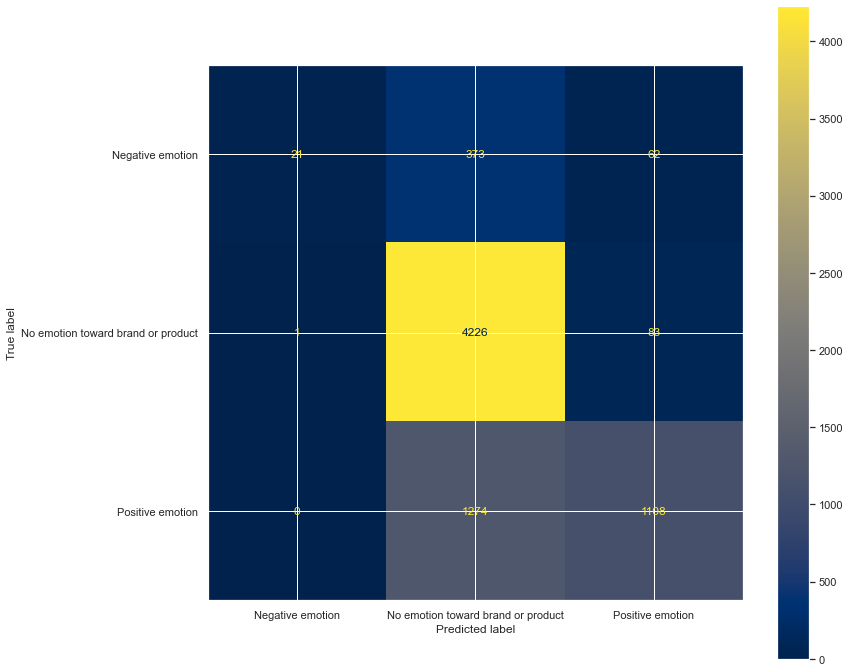

In [25]:
nb = MultinomialNB()

nb.fit(X_train_vectorized, y_train)

fig, ax = plt.subplots(figsize=(12,12))
plot_confusion_matrix(nb, X_train_vectorized, y_train, ax=ax, cmap="cividis");

In [17]:
preds = nb.predict(X_train_vectorized)
f1_score(y_train, preds, average='weighted')
f1_score(y_train, preds, average='micro')
f1_score(y_train, preds, average=None)

array([0.08786611, 0.8300108 , 0.60962861])

In [18]:
preds = nb.predict(X_train_vectorized)
f1_score(y_train, preds, average='weighted')

0.7092261967476263

In [19]:
f1_score(y_train, preds, average='micro')

0.7491606043648573

In [20]:
f1_score(y_train, preds, average=None)

array([0.08786611, 0.8300108 , 0.60962861])

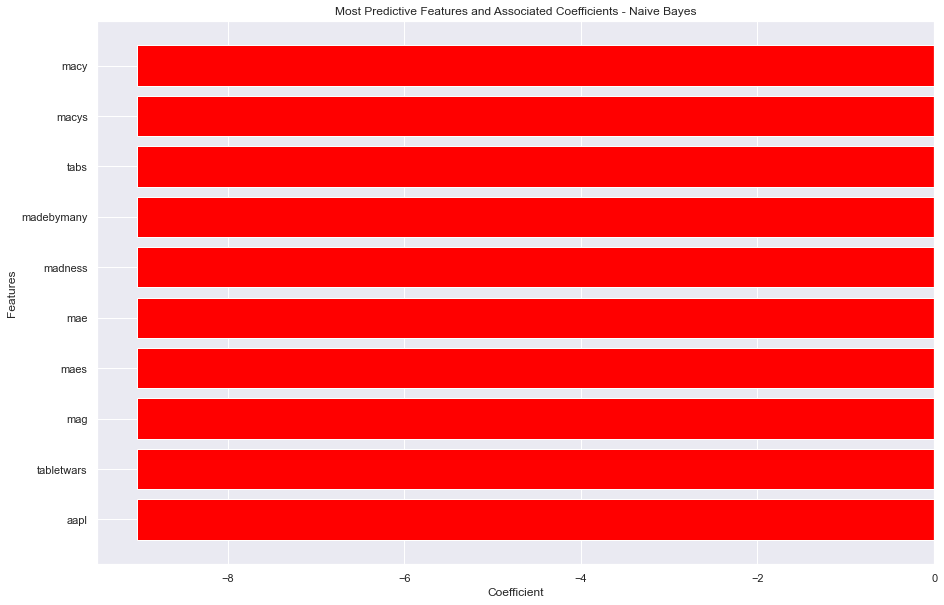

In [49]:
# get the coefficient and sort them
coef = nb.coef_[0]
top_positive_coefficients = np.argsort(coef)[:10]


plt.figure(figsize=(15, 10))
colors = ['red' if c < 0 else 'blue' for c in coef[top_positive_coefficients]]
plt.barh(np.arange(len(top_positive_coefficients)), coef[top_positive_coefficients], color=colors)
feature_names = np.array(vectorizer.get_feature_names())
plt.yticks(np.arange(len(top_positive_coefficients)), feature_names[top_positive_coefficients], rotation=0, ha='right')
plt.ylabel('Features')
plt.xlabel('Coefficient')
plt.title('Most Predictive Features and Associated Coefficients - Naive Bayes')
plt.show()

In [ ]:
rfc = RandomForestClassifier(random_state=13)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
svc = SVC(random_state=13)

rfc_grid = {
    'max_depth':[10,15,20,25,30],
    'min_samples_split':[10,15,20,25,30]
}
knc_grid = {
    'n_neighbors':[3,5,7,9]
}
mnb_grid = {
}
svc_grid = {
    'kernel':['poly','rbf'],
    'degree':[3,4,5]
}

rfc = GridSearchCV(
    rfc,rfc_grid
)
knc = GridSearchCV(
    knc,knc_grid
)
mnb = GridSearchCV(
    mnb,mnb_grid
)
svc = GridSearchCV(
    svc,svc_grid
)

classifiers = [rfc,knc,mnb,svc]


o = SMOTE()
pipe = imbPipeline(
    steps=[
        ('o',o),
        ('search',DummyClassifier())
        # ()
    ]
)

scoring = 'f1_weighted'

grid = {
    'o':['passthrough',o],
    # 'o__k_neighbors':[3,5,7],
    'search':[*classifiers]
}

gs = GridSearchCV(
    pipe,grid,scoring=scoring,
    verbose=1, n_jobs=-1
)
gs.fit(X_train_vectorized, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


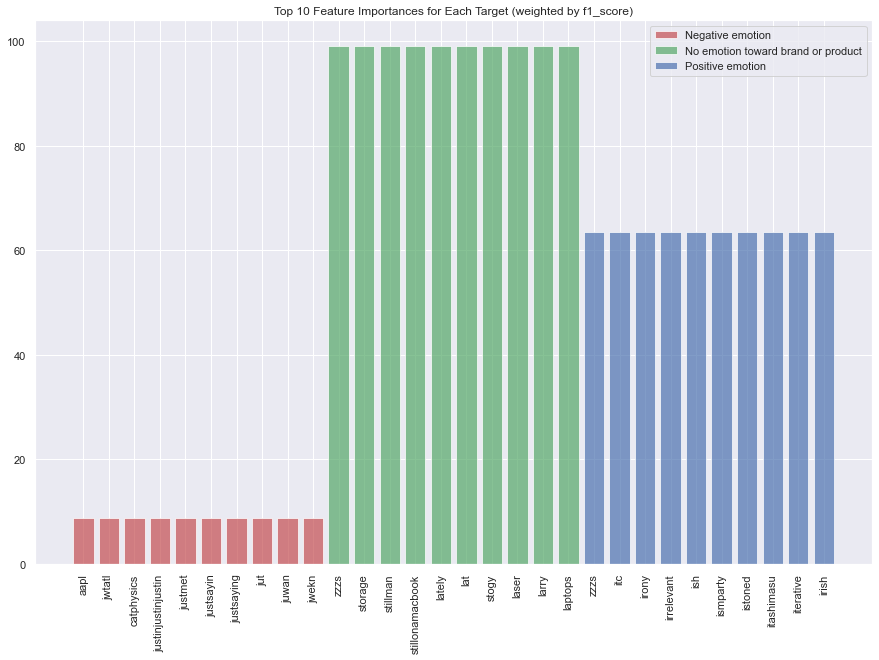

In [46]:
from sklearn.metrics import f1_score

def plot_feature_importance(model, X, y):
    y = np.array(y)  # Convert y to numpy array
    target_names = np.unique(y)
    n_targets = len(target_names)
    
    if hasattr(model, 'feature_importances_'):
        feat_imp_all = model.feature_importances_.reshape(n_targets, -1)
    else:
        feat_imp_all = np.log(np.abs(model.coef_))
    
    f1_scores = []
    for t in range(n_targets):
        X_subset = X[np.where(y == target_names[t])]
        y_subset = y[np.where(y == target_names[t])]
        y_pred_subset = model.predict(X_subset)
        f1_scores.append(f1_score(y_subset, y_pred_subset, average='weighted'))
    
    f1_scores = np.array(f1_scores)
    plt.figure(figsize=(15, 10))
    colors = ['r', 'g', 'b']
    all_sorted_idx = []
    
    for t, target_name in enumerate(target_names):
        feat_imp = 100.0 * (feat_imp_all[t] * f1_scores[t] / feat_imp_all[t].max())
        sorted_idx = np.argsort(feat_imp)[::-1][:10]
        all_sorted_idx.extend(sorted_idx)

        plt.bar(np.arange(t * 10, t * 10 + 10), feat_imp[sorted_idx], color=colors[t], alpha=.7)

    plt.xticks(np.arange(30), np.array(vectorizer.get_feature_names())[all_sorted_idx], rotation=90)
    plt.title("Top 10 Feature Importances for Each Target (weighted by f1_score)")
    plt.legend(target_names)
    plt.show()

plot_feature_importance(nb, X_train_vectorized, y_train)

In [ ]:
    for column in data.columns:
        if column in stock_param:
            color = 'black'
            color_list.append(color)
        if column in tweets_param:
            color = 'deepskyblue'
            color_list.append(color)
        if column in news_param:
            color = 'b'
            color_list.append(color)